1. Imports & Global Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from joblib import dump

warnings.filterwarnings('ignore', category=FutureWarning)
plt.style.use('seaborn-v0_8-whitegrid')

2. Data Loading, Time-of-Day Bucketing & Round Assignment

In [2]:
usecols = [
    'Time','HomeTeam','AwayTeam','FTHG','FTAG','FTR','Referee',
    'HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR',
    'B365H','B365D','B365A','B365>2.5','B365<2.5'
]
file_path = r"D:\python\premier league predictor\premier league data\premier leaguer 23-24.csv"
df = pd.read_csv(file_path, usecols=usecols)

df['MatchIndex'] = df.index + 1
df['Round']      = np.ceil(df['MatchIndex'] / 10).astype(int)

df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce').dt.hour
bins   = [-1, 11, 17, 24]
labels = ['Morning','Afternoon','Evening']
df['TimeOfDay'] = pd.cut(df['Hour'], bins=bins, labels=labels)
df.drop(columns='Hour', inplace=True)

print("Loaded shape:", df.shape)

Loaded shape: (380, 27)


3. Leakage-Free Feature Engineering

In [3]:
# %% [markdown]
# ## Step 3: Leakage-Free Feature Engineering
# Construct predictive features using only historical or observable data at each round.
# Features include outcome mapping, implied probabilities, odds spread, rolling form and streaks,
# interaction terms, referee bias, head-to-head history, rolling match stats, and previous-round positions.

# %%
# 3.1 Targets: match outcome and goal-over-under indicator
df['Outcome'] = df['FTR'].map({'H': 1, 'D': 0, 'A': -1})
df['Over2.5'] = ((df['FTHG'] + df['FTAG']) >= 3).astype(int)

# 3.2 Implied probabilities from betting odds
for side in ['H', 'D', 'A']:
    df[f'ImpProb_{side}'] = 1.0 / df[f'B365{side}']
prob_cols = ['ImpProb_H', 'ImpProb_D', 'ImpProb_A']
df[prob_cols] = df[prob_cols].div(df[prob_cols].sum(axis=1), axis=0)

df['ImpOver2.5']  = 1.0 / df['B365>2.5']
df['ImpUnder2.5'] = 1.0 / df['B365<2.5']
df[['ImpOver2.5', 'ImpUnder2.5']] = (
    df[['ImpOver2.5', 'ImpUnder2.5']]
      .div(df[['ImpOver2.5', 'ImpUnder2.5']].sum(axis=1), axis=0)
)

# 3.3 Odds spread
df['OddsSpread'] = df['B365H'] - df['B365A']

# 3.4 Rolling 3-match form
df['HomeForm3'] = (
    df.groupby('HomeTeam')['Outcome']
      .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
)
df['AwayForm3'] = (
    df.groupby('AwayTeam')['Outcome']
      .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
)

# 3.5 Win/loss streaks
df['HomeStreak'] = (
    df.groupby('HomeTeam')['Outcome']
      .transform(lambda s:
          s.eq(1).shift(1).fillna(0).astype(int)
           .groupby((~s.eq(1)).cumsum()).cumsum()
      )
)
df['AwayStreak'] = (
    df.groupby('AwayTeam')['Outcome']
      .transform(lambda s:
          s.eq(-1).shift(1).fillna(0).astype(int)
           .groupby((~s.eq(-1)).cumsum()).cumsum()
      )
)

# 3.6 Interaction term
df['Spread×Form'] = df['OddsSpread'] * df['HomeForm3']

# 3.7 Referee home-bias estimation
df['RefHomeWins'] = (
    df.groupby('Referee')['Outcome']
      .transform(lambda s: s.eq(1).cumsum().shift(1).fillna(0))
)
df['RefMatches'] = df.groupby('Referee').cumcount()
df['RefBias']    = (df['RefHomeWins'] / df['RefMatches']).fillna(0.5)
df.drop(columns=['RefHomeWins', 'RefMatches'], inplace=True)

# %% [markdown]
# ### Step 3.8: Head-to-Head Last Result
# Track the most recent result between the two teams from the perspective of the home side.

# %%
df['PairKey'] = df.apply(
    lambda r: tuple(sorted([r.HomeTeam, r.AwayTeam])), axis=1
)
h2h = {}
def prev_h2h(row):
    key = row.PairKey
    prev = h2h.get(key, 0)
    sign = 1 if row.HomeTeam == key[0] else -1
    h2h[key] = row.Outcome * sign
    return prev

df['H2H_Last'] = df.apply(prev_h2h, axis=1)
df.drop(columns='PairKey', inplace=True)

# %% [markdown]
# ### Step 3.9: Rolling Match-Stat Averages
# Compute rolling 3-match averages for key match statistics (shots, fouls, cards).

# %%
home_stats = ['HS','HST','HF','HC','HY','HR']
away_stats = ['AS','AST','AF','AC','AY','AR']
for stat in home_stats:
    df[f'Home_{stat}_3'] = (
        df.groupby('HomeTeam')[stat]
          .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
    )
for stat in away_stats:
    df[f'Away_{stat}_3'] = (
        df.groupby('AwayTeam')[stat]
          .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
    )

# %% [markdown]
# ### Step 3.10: Previous-Round Table Position
# Calculate each team’s cumulative points and league position as of the previous round.

# %%
df['HomePts'] = np.where(df['FTR']=='H', 3, np.where(df['FTR']=='D', 1, 0))
df['AwayPts'] = np.where(df['FTR']=='A', 3, np.where(df['FTR']=='D', 1, 0))

pts = pd.DataFrame({
    'Team':  np.concatenate([df['HomeTeam'], df['AwayTeam']]),
    'Round': np.concatenate([df['Round'],    df['Round']]),
    'Pts':   np.concatenate([df['HomePts'],  df['AwayPts']])
})
round_pts = (
    pts.groupby(['Team','Round'], as_index=False)['Pts']
        .sum()
)
round_pts['CumPts'] = round_pts.groupby('Team')['Pts'].cumsum()
round_pts['Pos']    = (
    round_pts.groupby('Round')['CumPts']
        .rank(method='min', ascending=False)
)

prev = round_pts[['Team','Round','Pos']].copy()
prev.rename(columns={'Round':'PrevRound','Pos':'PrevPos'}, inplace=True)
prev['PrevRound'] += 1

df = df.merge(
    prev, left_on=['HomeTeam','Round'],
    right_on=['Team','PrevRound'], how='left'
)
df['HomePosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team','PrevRound','PrevPos'], inplace=True)

df = df.merge(
    prev, left_on=['AwayTeam','Round'],
    right_on=['Team','PrevRound'], how='left'
)
df['AwayPosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team','PrevRound','PrevPos'], inplace=True)

4. Pipeline Specification & Hyperparameter Distributions

In [4]:
from scipy.stats import randint, uniform

# categorical features (unchanged)
cat_feats = ['HomeTeam', 'AwayTeam', 'Referee', 'TimeOfDay']

# numeric features (unchanged)
num_feats = [
    'HomeForm3','AwayForm3','HomeStreak','AwayStreak',
    'ImpProb_H','ImpProb_D','ImpProb_A',
    'ImpOver2.5','ImpUnder2.5',
    'OddsSpread','Spread×Form','RefBias','H2H_Last',
    'HomePosPrev','AwayPosPrev'
] + [f'Home_{s}_3' for s in home_stats] \
  + [f'Away_{s}_3' for s in away_stats]

# fill any remaining NaNs in numeric features
df[num_feats] = df[num_feats].fillna(0)

# reuse the exact same preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_feats),
], remainder='drop')

# hyperparameter distributions adapted for XGBClassifier
param_dist = {
    'clf__n_estimators':    [100, 200, 500],
    'clf__max_depth':       [3, 10, 20, 30],
    'clf__min_child_weight':[1, 2, 4],
    'clf__subsample':       [0.5, 0.7, 1.0],
    'clf__colsample_bytree':[0.3, 0.5, 0.8],
    'clf__learning_rate':   [0.01, 0.1, 0.2]
}

# factory for our XGBoost pipeline
def make_model_xgb():
    return Pipeline([
        ('prep', preprocessor),
        ('clf', XGBClassifier(
            random_state=42,
            n_jobs=-1,
            use_label_encoder=False,
            eval_metric='mlogloss'
        ))
    ])

5. Round-by-Round Training & Prediction with Tuning

In [5]:
preds, actuals, rounds, match_indices = [], [], [], []
warmup = 50   # initial warm-up for a quick fit

# Remap Outcome: -1 → 0, 0 → 1, 1 → 2
outcome_map = {-1: 0, 0: 1, 1: 2}
df['Outcome_XGB'] = df['Outcome'].map(outcome_map)

# 5.1 Warm-up fit with default XGB (no tuning)
model = make_model_xgb()
model.set_params(clf__n_estimators=500)
model.fit(
    df.loc[:warmup-1, cat_feats + num_feats],
    df.loc[:warmup-1, 'Outcome_XGB']
)

# 5.2 Round-by-round loop with RandomizedSearchCV
for r in range(6, df['Round'].max() + 1):
    train_idx = df['Round'] < r
    test_idx  = df['Round'] == r

    X_train = df.loc[train_idx,  cat_feats + num_feats]
    y_train = df.loc[train_idx,  'Outcome_XGB']
    X_test  = df.loc[test_idx,   cat_feats + num_feats]
    y_test  = df.loc[test_idx,   'Outcome_XGB']

    search = RandomizedSearchCV(
        estimator=make_model_xgb(),
        param_distributions=param_dist,
        n_iter=10,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    search.fit(X_train, y_train)
    model = search.best_estimator_

    y_pred = model.predict(X_test)

    # Map predictions & actuals back to original labels
    inv_outcome_map = {v: k for k, v in outcome_map.items()}
    remapped_pred = [inv_outcome_map[p] for p in y_pred]
    remapped_true = [inv_outcome_map[a] for a in y_test.values]

    preds.extend(remapped_pred)
    actuals.extend(remapped_true)
    rounds.extend([r] * len(remapped_true))
    match_indices.extend(df.loc[test_idx, 'MatchIndex'].tolist())

    # optional: per-round evaluation
    acc = accuracy_score(remapped_true, remapped_pred)
    print(f"Round {r}: accuracy = {acc:.3f}")

print(f"Predicted rounds 6 to {df['Round'].max()}")

# Save the final trained XGB pipeline for interface
final_model = model

c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:45:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:47:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 6: accuracy = 0.500


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:47:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 7: accuracy = 0.500


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:47:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 8: accuracy = 0.600


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:47:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 9: accuracy = 0.700


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:47:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 10: accuracy = 0.500


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:47:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 11: accuracy = 0.100


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:47:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 12: accuracy = 0.600


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:48:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 13: accuracy = 0.300


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:48:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 14: accuracy = 0.500


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:48:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 15: accuracy = 0.800


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:48:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 16: accuracy = 0.200


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:48:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 17: accuracy = 0.700


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:48:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 18: accuracy = 0.400


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:49:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 19: accuracy = 0.800


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:49:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 20: accuracy = 0.500


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:49:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 21: accuracy = 0.500


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 22: accuracy = 0.500


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 23: accuracy = 0.800


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 24: accuracy = 0.700


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 25: accuracy = 0.500


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 26: accuracy = 0.700


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:51:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 27: accuracy = 0.700


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:51:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 28: accuracy = 0.500


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:51:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 29: accuracy = 0.600


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:52:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 30: accuracy = 0.600


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:52:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 31: accuracy = 0.600


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:52:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 32: accuracy = 0.300


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:52:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 33: accuracy = 0.500


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 34: accuracy = 0.600


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 35: accuracy = 0.900


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 36: accuracy = 0.700


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 37: accuracy = 0.800


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Round 38: accuracy = 0.600
Predicted rounds 6 to 38


6. Assemble, Save Results & Final Model

In [6]:
# 6.1 Assemble DataFrame of predictions
df_idx = df.set_index('MatchIndex')
homes = [df_idx.loc[i, 'HomeTeam'] for i in match_indices]
aways = [df_idx.loc[i, 'AwayTeam'] for i in match_indices]

results_df = pd.DataFrame({
    'MatchIndex': match_indices,
    'Round':       rounds,
    'HomeTeam':    homes,
    'AwayTeam':    aways,
    'Actual':      actuals,
    'Predicted':   preds
})

label_map = {1: 'H', 0: 'D', -1: 'A'}
results_df['ActualLabel'] = results_df['Actual'].map(label_map)
results_df['PredLabel']   = results_df['Predicted'].map(label_map)

# 6.2 Save predictions to Excel
output_path = r"D:\python\premier league predictor\xgb_predictions_vs_actuals.xlsx"
results_df.to_excel(output_path, index=False)
print("Results written to", output_path)

# 6.3 Save final trained XGBoost pipeline
dump(final_model, r"D:\python\premier league predictor\xgb_pl_pipeline.joblib")
print("Final XGBoost pipeline saved.")

Results written to D:\python\premier league predictor\xgb_predictions_vs_actuals.xlsx
Final XGBoost pipeline saved.


7. Results & Visualization

Overall accuracy = 0.570


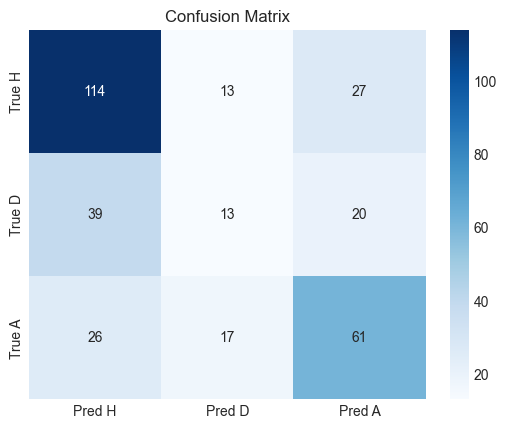

C:\Users\markf\AppData\Local\Temp\ipykernel_17608\3827096360.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: accuracy_score(g['True'], g['Pred']))


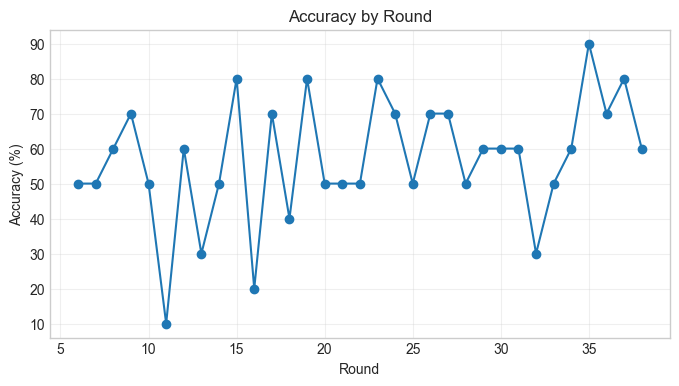

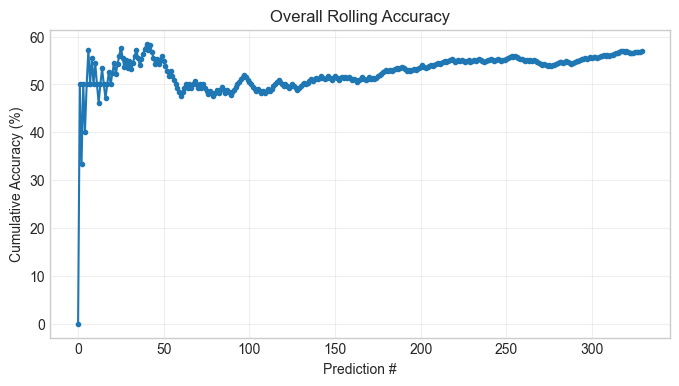

In [7]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

# 7.0 Overall accuracy (text)
from sklearn.metrics import accuracy_score

if 'predictions_df' in globals() and {'y_true','y_pred'}.issubset(predictions_df.columns) and len(predictions_df) > 0:
    overall_acc = (predictions_df['y_true'] == predictions_df['y_pred']).mean()
elif 'results_df' in globals() and {'Actual','Predicted'}.issubset(results_df.columns) and len(results_df) > 0:
    overall_acc = (results_df['Actual'] == results_df['Predicted']).mean()
elif 'actuals' in globals() and 'preds' in globals() and len(actuals) == len(preds) and len(actuals) > 0:
    overall_acc = accuracy_score(actuals, preds)
else:
    overall_acc = float('nan')

print(f"Overall accuracy = {overall_acc:.3f}")

# 7.1 Confusion matrix
cm = confusion_matrix(actuals, preds, labels=[1, 0, -1])
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Pred H', 'Pred D', 'Pred A'],
    yticklabels=['True H', 'True D', 'True A']
)
plt.title('Confusion Matrix')
plt.show()

# 7.2 Round-by-round accuracy
res = pd.DataFrame({
    'Round': rounds,
    'Pred': preds,
    'True': actuals
})
round_acc = res.groupby('Round') \
               .apply(lambda g: accuracy_score(g['True'], g['Pred']))

plt.figure(figsize=(8, 4))
plt.plot(round_acc.index, round_acc.values * 100, marker='o')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy by Round')
plt.grid(alpha=0.3)
plt.show()

# 7.3 Cumulative rolling accuracy
cum_acc = np.cumsum(np.array(preds) == np.array(actuals)) \
          / np.arange(1, len(preds) + 1)
plt.figure(figsize=(8, 4))
plt.plot(cum_acc * 100, marker='.')
plt.xlabel('Prediction #')
plt.ylabel('Cumulative Accuracy (%)')
plt.title('Overall Rolling Accuracy')
plt.grid(alpha=0.3)
plt.show()

8. Gradio Interface

In [8]:
import gradio as gr
import pandas as pd
import numpy as np

# ----------------------------------------------------------------------------
# Precompute the training-set means of the odds-derived features:
# ----------------------------------------------------------------------------
odd_feats = [
    'ImpProb_H','ImpProb_D','ImpProb_A',
    'ImpOver2.5','ImpUnder2.5','OddsSpread'
]
odd_means = df[odd_feats].mean()

# ----------------------------------------------------------------------------
# Gradio dropdown choices:
# ----------------------------------------------------------------------------
teams = sorted(df['HomeTeam'].unique())
refs  = sorted(df['Referee'].unique())
times = ['Morning','Afternoon','Evening']

# ----------------------------------------------------------------------------
# Prediction function
# ----------------------------------------------------------------------------
def predict_outcome(home_team, away_team, referee, time_of_day):
    # 1) Pull the last historical row for each entity
    home = df[df.HomeTeam == home_team].iloc[-1]
    away = df[df.AwayTeam == away_team].iloc[-1]
    ref  = df[df.Referee == referee].iloc[-1]
    
    # 2) Assemble the feature dict
    data = {}
    
    # 2a) Odds-derived features: fill with their training-set means
    for feat in odd_feats:
        data[feat] = odd_means[feat]
    
    # 2b) Rolling form & streaks
    data['HomeForm3']  = home['HomeForm3']
    data['AwayForm3']  = away['AwayForm3']
    data['HomeStreak'] = home['HomeStreak']
    data['AwayStreak'] = away['AwayStreak']
    
    # 2c) Interaction term
    data['Spread×Form'] = data['OddsSpread'] * data['HomeForm3']
    
    # 2d) Referee bias
    data['RefBias'] = ref['RefBias']
    
    # 2e) Head-to-head last
    pair = ((df.HomeTeam==home_team)&(df.AwayTeam==away_team)) | \
           ((df.HomeTeam==away_team)&(df.AwayTeam==home_team))
    data['H2H_Last'] = df[pair].iloc[-1]['H2H_Last']
    
    # 2f) Previous round positions
    data['HomePosPrev'] = home['HomePosPrev']
    data['AwayPosPrev'] = away['AwayPosPrev']
    
    # 2g) Rolling match-stats (shots, fouls, cards)
    for s in home_stats:
        data[f'Home_{s}_3'] = home[f'Home_{s}_3']
    for s in away_stats:
        data[f'Away_{s}_3'] = away[f'Away_{s}_3']
    
    # 2h) Categorical features
    data['HomeTeam']  = home_team
    data['AwayTeam']  = away_team
    data['Referee']   = referee
    data['TimeOfDay'] = time_of_day
    
    # 3) Predict probabilities with the final XGB pipeline
    Xnew  = pd.DataFrame([data])
    probs = final_model.predict_proba(Xnew)[0]
    classes = list(final_model.classes_)  # e.g. [-1,0,1]
    
    return (
        float(probs[classes.index(1)] * 100),
        float(probs[classes.index(0)] * 100),
        float(probs[classes.index(-1)] * 100)
    )

# ----------------------------------------------------------------------------
# Launch Gradio interface
# ----------------------------------------------------------------------------
iface = gr.Interface(
    fn=predict_outcome,
    inputs=[
        gr.Dropdown(teams, label="Home Team"),
        gr.Dropdown(teams, label="Away Team"),
        gr.Dropdown(refs,  label="Referee"),
        gr.Dropdown(times, label="Time of Day"),
    ],
    outputs=[
        gr.Number(label="Home Win %"),
        gr.Number(label="Draw %"),
        gr.Number(label="Away Win %")
    ],
    title="Premier League Outcome Predictor (XGBoost)",
    description=(
        "Select Home/Away teams, Referee and Time of Day. "
        "Odds-derived features are filled with their historical averages, "
        "all other features are pulled from past matches."
    )
)

iface.launch()

* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.
